### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [2]:
import re
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [6]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
RES_PATH = 'data/result_submission.csv'

### Загрузка данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Feature engineering / Работа с признаками

In [8]:
def feature_engineering(df):
    # Построение новых признаков
    df['high_rate'] = (df['mean_exam_points'] >= 44) & (df['lesson_price'] <= 2700).astype('bool')
    df['q_lp_ratio'] =  df['qualification'] / df['lesson_price']
    df['q_lp_deratio'] =  df['qualification'] * df['lesson_price']

In [9]:
feature_engineering(train_df)
feature_engineering(test_df)

### Корреляция признаков

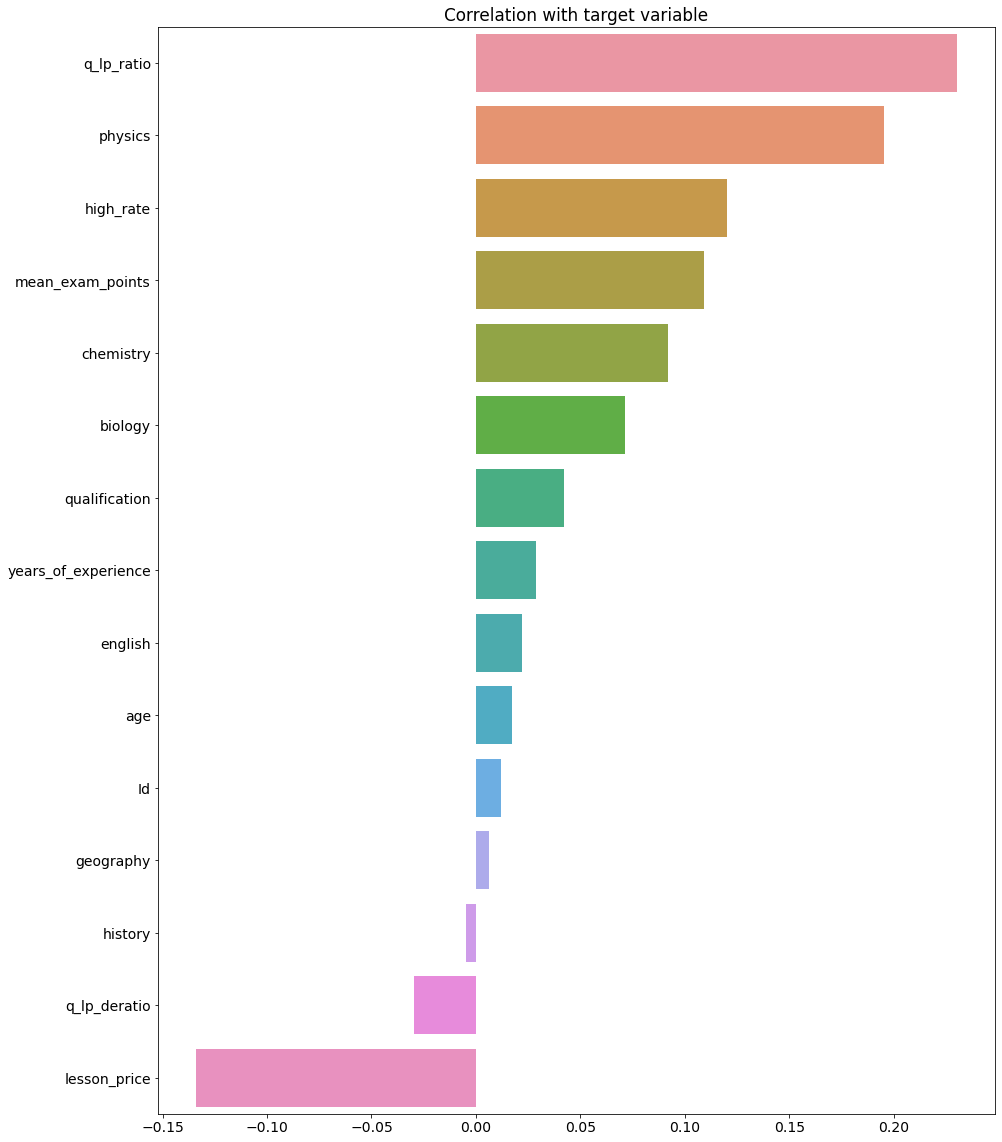

In [10]:
TARGET_NAME = 'choose'

corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

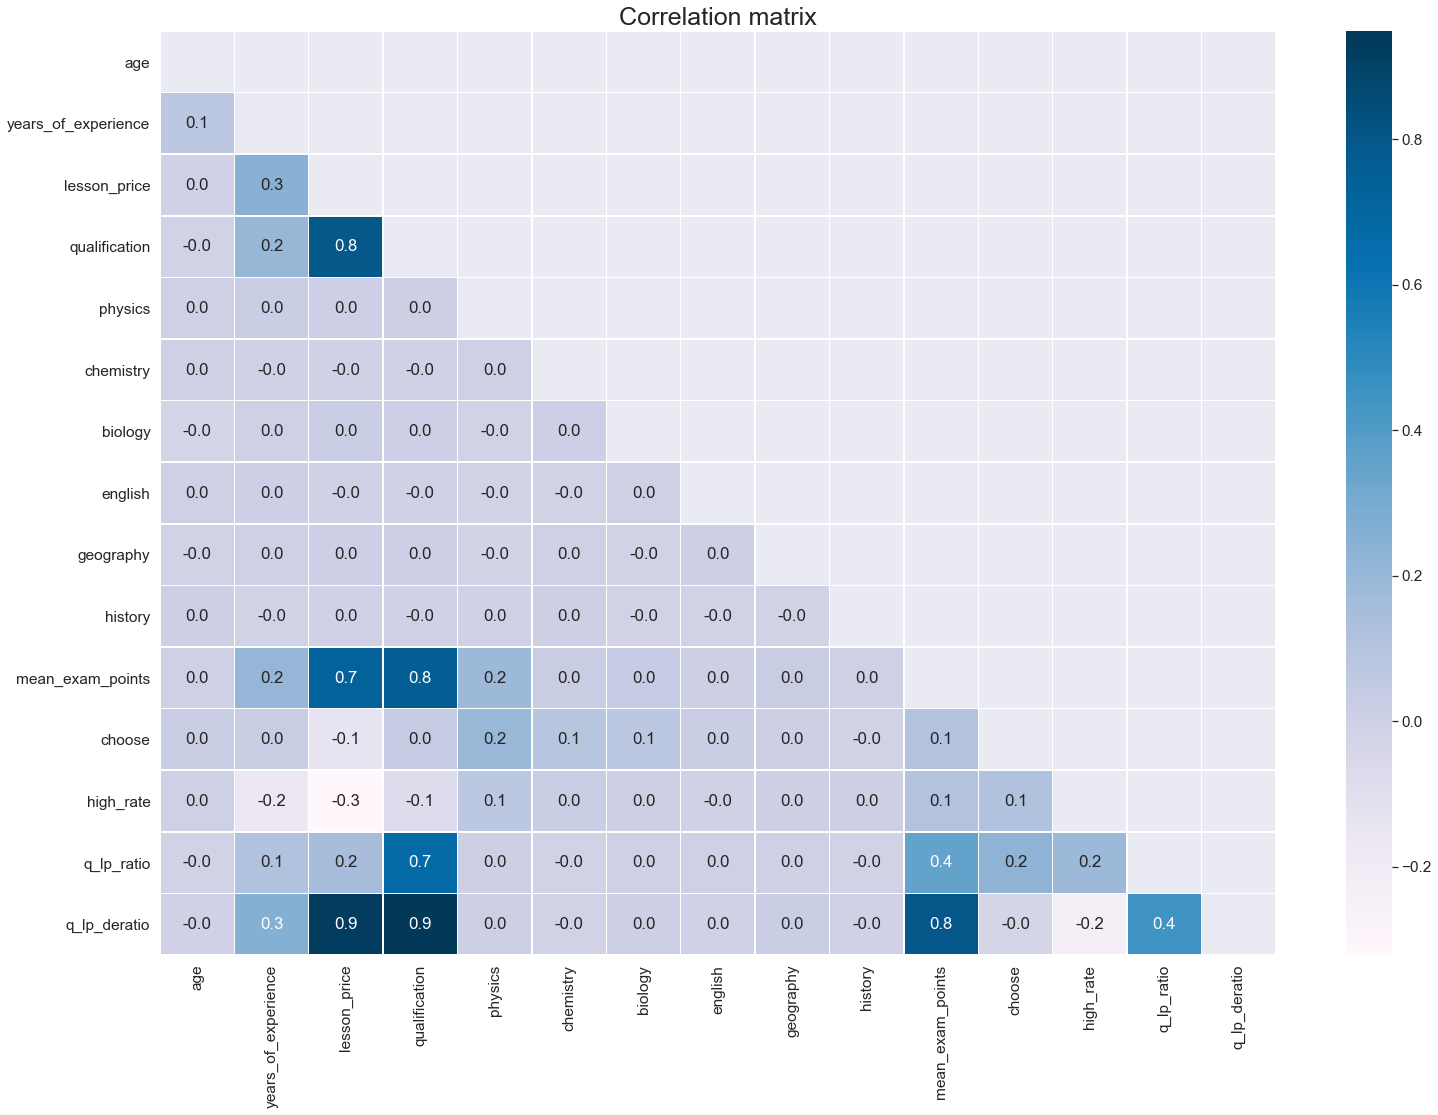

In [11]:
# Correlation Matrix
num_features = pd.DataFrame(train_df)
num_features.drop('Id', axis=1, inplace=True)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix', fontsize=25)
plt.show()

### Создание класса модели - метод наименьших квадратов

In [12]:
# Класс модели "Метод наименьших квадратов"
class mnk_model():
    
    def __init__(self, prediction_type='classification', true_point=0.5, L1=0, L2=0):
        self.prediction_type = prediction_type # Тип предсказания - 'classification', 'regression' (бинарная классификация)
        self.true_point = true_point           # Точка разделения классов на базе predict_proba для бинарной классификации
        self.L1 = L1                           # Коэф для L1 регуляризации
        self.L2 = L2                           # Коэф для L2 регуляризации
    
    
    def fit(self, X_train, y_train):
        self.X_train = np.hstack((np.ones(len(X_train)).reshape(-1,1), np.array(X_train)))
        self.y_train = np.array(y_train)
        
        X, y, L2, L1 = self.X_train, self.y_train, self.L2, self.L1
        
        #self.W_mnk = np.linalg.inv(X.T @ X) @ X.T @ y                            # без регулярихации
        #self.W_mnk = np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ X.T @ y  # только L2 регулярихации
        
        s = np.sign(np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ X.T @ y)
        self.W_mnk = np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ (X.T @ y - L1 * s)

        
    def train(self, X_train, y_train):
        fit(self, X_train, y_train)
    
    
    def predict(self, X_test):
        sigmoid = lambda z: 1/(np.exp(-z)+1)
        
        X_test = np.hstack((np.ones(len(X_test)).reshape(-1,1), X_test))
        y_test_pred = X_test @ self.W_mnk
        
        if self.prediction_type == 'classification' :
            y_test_pred = (sigmoid(y_test_pred - 0.5) > self.true_point).astype('int')
        
        return y_test_pred
    
    
    def predict_proba(self, X_test):
        sigmoid = lambda z: 1/(np.exp(-z)+1)
        X_test = np.hstack((np.ones(len(X_test)).reshape(-1,1), np.array(X_test)))
        y_test_pred_proba = sigmoid(X_test @ self.W_mnk - 0.5)
        
        return np.vstack((1-y_test_pred_proba, y_test_pred_proba)).T
    
    
    def coef_(self):
        print('\nВеса признаков:\n', np.round(self.W_mnk[1:],4), 
              '\nИнтерсепт:', np.round(self.W_mnk[0],4))
        return self.W_mnk

In [13]:
# Разбивка на фолды стратифицированная по значению целевой переменной
def SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=5, random_state=42):
    # Определение кол-ва слоев
    layers_qty = min(max_layers_qty, np.unique(df[TARGET_NAME]).shape[0])
    
    # Определение значения целевой переменной для разбивки на слои
    split_points = np.linspace(np.min(df[TARGET_NAME]), np.max(df[TARGET_NAME]), layers_qty+1)
    
    # Формирование списка со значениями индексов слоев и списка содержащего фолды для тренировки и валидации
    layers=[]
    SKF_list = [[np.array([]),np.array([])] for i in range(n_splits)]
    
    np.random.seed(random_state) 
    
    for i in range(len(split_points)-1):
        # Определение индекса элементов входящих в слой
        if i == len(split_points)-2:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]<=split_points[i+1])].index)
        else:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]< split_points[i+1])].index)
    
        np.random.shuffle(layer_index)
        b_qty = layer_index.shape[0] // n_splits

        for j in range(n_splits):
            if j == n_splits - 1:              
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j:]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0:b_qty * j]))
            else:
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j: b_qty * (j+1)]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0: b_qty * j], layer_index[b_qty * (j+1):]))
            
    return SKF_list

In [14]:
# Функция масштабирования данных (аналог StandardScaler и MinMaxScaler)
class scaler():
    
    def __init__(self, scaler_type='std'):
        self.scaler_type = scaler_type
        self.min = 0
        self.max = 0
        self.std = 0
        self.mean = 0
    
    
    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        self.std = np.std(data, axis=0)
        self.mean = np.mean(data, axis=0)
        return self
    
    
    def train(self, data):
        fit(self, data)
    
    
    def transform (self, data):
        if self.scaler_type == 'std':
            return (data - self.mean) / self.std
        
        if self.scaler_type == 'norm':
            return (data - self.mean) / self.std      
        
        if self.scaler_type == 'none':
            return data
    
    
    def fit_transform(self, data):
        fit(self, data)
        transform (self, data)

In [15]:
# Балансировка по целевому классу
def balance_df_by_target(df, TARGET_NAME, portion_of_target_class=0.5, random_state=17, balance_type='add'):
    df_tmp = df.copy()
    counts_0 = (df_tmp[TARGET_NAME] == 0).sum()
    counts_1 = (df_tmp[TARGET_NAME] == 1).sum()
    
    if balance_type == 'add':
        if portion_of_target_class > (counts_1 / (df.shape[0])):
            disbalance = int(counts_0 / (1-portion_of_target_class) - df.shape[0])
            add_class = 1
        else:
            disbalance = int(counts_1 / portion_of_target_class - df.shape[0])
            add_class = 0

        sample = df_tmp[df_tmp[TARGET_NAME] == add_class].sample(n=disbalance, replace=True, random_state=random_state)
        df_tmp = pd.concat([sample, df_tmp], axis=0)
    
    return df_tmp

In [16]:
def short_model_score_report(y_true, y_pred, y_pred_proba, name, header=True, model_type='classification'):
    # Отчет для модели классификации
    if model_type == 'classification':
        f1 = round(f1_score(y_true, y_pred),4)
        pr = round(precision_score(y_true, y_pred),4)
        re = round(recall_score(y_true, y_pred),4)
        roc = round(roc_auc_score(y_true, y_pred_proba),4)
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}{:>17}\033[0m'.format('Model', 'precision', 'recall', 'f1-score', 'roc_auc'))
        print('{:<20}{:>12}{:>17}{:>17}{:>17}'.format(name, pr, re, f1, roc))
    
    # Отчет для модели регрессии
    mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
    
    if model_type == 'regression':
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        rmse_err = lambda y, y_pred : mse_err(y, y_pred) ** 0.5
        mae_err = lambda y, y_pred : np.mean(np.abs(y - y_pred))
        r2_calc = lambda y, y_pred : 1 - mse_err(y, y_pred) / mse_err(y, np.mean(y))
        
        mae = round(mae_err(y_true, y_pred),4)
        rmse = round(rmse_err(y_true, y_pred),4)
        r2 =  round(r2_calc(y_true, y_pred),4)
        
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}\033[0m'.format('Model', 'MAE', 'RMSE', 'R2'))
        print('{:<20}{:>12}{:>17}{:>17}'.format(name, mae, rmse, r2))

In [17]:
# Функция расчета метрики accuracy
def accuracy_score(y_true, y_pred):     
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return (tp + tn) / (tp + tn + fp + fn)


# Функция расчета метрики precisiion
def precision_score(y_true, y_pred):    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return tp / (tp + fp)
 
    
# Функция расчета метрики recall
def recall_score(y_true, y_pred):    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return tp / (tp + fn)


# Функция расчета метрики f1
def f1_score(y_true, y_pred):  
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    recall = tp / (tp + fn)
    precission = tp / (tp + fp)
    
    b = 1
    f1 = (1 + b**2) * (recall * precission) /(b**2 * precission + recall) 
    
    return f1


# Функция расчета метрики ROC AUC для бинарной классификации
def roc_auc_score(y_true, y_pred_proba, plot=False):
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    
    prob_data=np.vstack((y_true, y_pred_proba)).T
    prob_data = prob_data[prob_data[:,1].argsort()][::-1]

    roc = np.zeros((y_true.shape[0]+1,2))

    tp = 0
    fp = 0
    fn = np.sum(y_true) 
    tn = y_true.shape[0] - np.sum(y_true)

    for i in range(prob_data.shape[0]):
        tp += prob_data[i,0]
        fn -= prob_data[i,0]
        tn -= prob_data[i,0] * (-1) + 1
        fp += prob_data[i,0] * (-1) + 1 
        roc[i+1,0] = fp / (fp + tn)
        roc[i+1,1] = tp / (tp + fn)
    
    roc_score = 0
    
    for i in range(roc.shape[0]-1):
        roc_score += (roc[i+1,0] - roc[i,0]) * roc[i,1] 

    return np.sum(roc_score)

In [18]:
def check_models(df=[],                      # датасет
               df_test=[],                   # датасет для которого нужно сформировать предсказания
               TARGET_NAME='',               # Имя столбца с целевой переменной
               models = [],                  # словарь моделей (обязательно  должны быть методы fit, predict)   
               target_class_ratio=0.5,       # коэффициент для балансровки соотношения классов целевой переменной
               random_state=42,              # Random_State
               SKF_splits=4,                 # кол-во фолдов для валидации
               fold_report=True,             # вывод репорта для каждого фолда
               train_report=False,           # вывод отчета для тренировочного датасета
               scaler_type='std',            # Функция масштабирования признаков ('none', 'std', 'norm')
               model_type='classification'): # тип предсказания :  'classification', 'regression'
    
    first_model = list(models.keys())[0]
    
    # Список для сохранения натренированных моделей
    model_list = []
    
    # Формирование датасетов для записи результатом работы моделей
    df_result = pd.DataFrame({'index': df.index, TARGET_NAME: df[TARGET_NAME]})
    df_test_result = pd.DataFrame({'index': df_test.index})
    
    for i in models.keys():
        df_result[i], df_result[i + '_p'] = float("NaN"), float("NaN")
        df_test_result[i], df_test_result[i + '_p'] = np.zeros(df_test.shape[0]), np.zeros(df_test.shape[0])
        
    # Масштабирование данных для моделей (критично для линейных моделей)
    df_scaled = df.copy()
    df_test_scaled = df_test.copy()
    scaler_cols= df.drop(columns=TARGET_NAME).columns
    
    data_scaler = scaler(scaler_type=scaler_type).fit(df[scaler_cols])
    df_scaled[scaler_cols] = data_scaler.transform(df[scaler_cols])
    df_test_scaled[scaler_cols] = data_scaler.transform(df_test[scaler_cols])
    
    # Разбивка на test и train 
    split = 0
    
    skf = SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=5, random_state=42)
    
    for train_index, valid_index in skf:
        split += 1
        
        
        df_train_processed = df_scaled.loc[train_index].copy()
        df_valid_processed = df_scaled.loc[valid_index].copy()
        X_test = df_test_scaled.copy()
            
        # Балансировка по целевому классу
        if model_type == 'classification':
            df_train_processed_balanced = balance_df_by_target(df_train_processed, 
                                                               TARGET_NAME, 
                                                               target_class_ratio, 
                                                               random_state=2)
        
        elif model_type == 'regression':
            df_train_processed_balanced = df_train_processed
        
        X_train = df_train_processed_balanced.drop(columns=TARGET_NAME)
        y_train = df_train_processed_balanced[TARGET_NAME]
        
        X_valid = df_valid_processed.drop(columns=TARGET_NAME)
        y_valid = df_valid_processed[TARGET_NAME]
        

        # Тренировка моделей
        for i in models.keys(): 
            models[i].fit(X_train, y_train)
            model_list.append([i, split, models[i]])
        
            # Запись предсказаний моделей в журнал
            y_valid_pred = models[i].predict(X_valid)
            df_result.loc[valid_index, i] = y_valid_pred
            df_test_result[i] += models[i].predict(X_test)
            
            if model_type == 'classification':
                y_valid_pred_proba = models[i].predict_proba(X_valid)[:,1]
                df_result.loc[valid_index, i + '_p'] = y_valid_pred_proba
                df_test_result[i + '_p'] += models[i].predict_proba(X_test)[:,1]
            elif model_type == 'regression':
                y_valid_pred_proba = np.zeros(X_valid.shape[0])
            
            # Формирование и вывод отчета по фолду
            if fold_report:
                if (i == first_model):
                    print('\nFold ' + str(split))
                
                short_model_score_report(y_valid, 
                                         y_valid_pred, 
                                         y_valid_pred_proba, 
                                         name=i + '_' +str(split) + '_valid', 
                                         header=(i == first_model),
                                         model_type=model_type)
                
                # Расчет и вывод отчета для тренировочных данных
                if train_report:
                    y_train_pred = models[i].predict(X_train).astype('int')
                    y_train_pred_proba = models[i].predict_proba(X_train)[:,1]
                    
                    short_model_score_report(y_train, 
                                             y_train_pred, 
                                             y_train_pred_proba, 
                                             name=len(i + '_' +str(split)) * ' ' + ' train',
                                             model_type=model_type)
                
    # Усреднение предсказаний каждой модели на фолдах
    df_test_result.loc[:,first_model:] = df_test_result.loc[:,first_model:] / SKF_splits 

    # Вывод финального отчета
    print('\nFinal report ({} folds AVG)'.format(SKF_splits))
    for i in models.keys():
        short_model_score_report(df_result[TARGET_NAME],
                                 df_result[i], df_result[i+'_p'],
                                 name=i,
                                 header=(i == first_model),
                                 model_type=model_type)
    
    y_valid = df[TARGET_NAME]
    y_valid_pred_proba = np.sum(df_result[[i + '_p' for i in models.keys()]],axis=1) / len(models.keys())
    
    if model_type == 'classification':
        y_valid_pred = np.round(y_valid_pred_proba).astype(int)
    elif model_type == 'regression':
        y_valid_pred = np.sum(df_result[[i for i in models.keys()]],axis=1) / len(models.keys())
    
    short_model_score_report(y_valid,
                             y_valid_pred,
                             y_valid_pred_proba,
                             name='Mix result ',
                             header=False,
                             model_type=model_type)
    
    return df_result, df_test_result, model_list

### Обучение модели

In [19]:
%%time

mnk = mnk_model(prediction_type='classification', L2=0.1, L1=4)

models = {'mnk': mnk}

df_result, df_test_result, model_list = check_models(df=train_df,
                                                   df_test=test_df,
                                                   TARGET_NAME=TARGET_NAME,
                                                   models = models,
                                                   target_class_ratio=0.50,
                                                   random_state=42,
                                                   SKF_splits=5,
                                                   fold_report=True,
                                                   train_report=False,
                                                   scaler_type='std',
                                                   model_type='classification')


Fold 1
Model                  precision           recall         f1-score          roc_auc
mnk_1_valid               0.2873           0.8009           0.4229           0.8646

Fold 2
Model                  precision           recall         f1-score          roc_auc
mnk_2_valid               0.2992           0.8054           0.4363           0.8559

Fold 3
Model                  precision           recall         f1-score          roc_auc
mnk_3_valid                0.281           0.7783            0.413           0.8635

Fold 4
Model                  precision           recall         f1-score          roc_auc
mnk_4_valid               0.2839           0.8054           0.4198           0.8513

Fold 5
Model                  precision           recall         f1-score          roc_auc
mnk_5_valid               0.2661           0.7511            0.393           0.8403

Final report (5 folds AVG)
Model                  precision           recall         f1-score          roc_auc
mnk     

### Прогнозирование и сохранение результатов

In [20]:
# Список столбоц в отчете df_test_result, которые необходимо вывести в качестве предсказания
predict_proba_cols = [2 + i*2 for i in range(int((df_test_result.shape[1] - 1) / 2))]

# Расчет усредненного предсказания вероятности по всем моделям
y_test_pred_proba = np.sum(df_test_result.iloc[:, predict_proba_cols], axis=1) / len(predict_proba_cols)

pd.DataFrame({'Id': test_df['Id'], TARGET_NAME: y_test_pred_proba}).to_csv(RES_PATH, index=False)

In [21]:
# from google.colab import files
# files.download('./result_submission.csv')